# Project 1: Measures of Centrality¶
### Data 620 Web Analytics
### Maliat Islam, Layla Quinones, and Karim Hammoud



## Introduction
In this project, we conducted a network analysis using NetworkX library on data gathered biannually by the Department of Mental Health and Hygene (DOHMH) through the civil birth registration, and made accessable to the public via <a href="https://data.cityofnewyork.us/Health/Popular-Baby-Names/25th-nujf" > NYC OPEN DATA </a>. This data details popular baby names in New York City along with information on year of birth, gender, ethnicity, number of babys with that name (count) and the frequency of baby names (rank). We developed a network analysis of this data so that we can better understand the relationship various baby names have with race.

<a href="https://www.youtube.com/watch?v=xv941lOexcQ" > 
Here is the video recording. </a>


## Data Import & Subsetting
We pull the data from NYC open source API and added the data is stored in a CSV format. Our data has been downloaded using Sodapy. Sodapy is a python client for the Socrata Open Data API. we will perform sertain analysis on our dataset. NYC OpenData was accessed using the Socrata API as below, we created a client connection and store the data in a pandas dataframe.

Write a brief description on how we imported the data
Write a brief description of how you subsetted the data

In [128]:
#import all needed libraries
import networkx as net, pandas as pd, numpy as np, re, matplotlib.pyplot as plt, warnings, seaborn as sns

# import Socrata to pull data
from sodapy import Socrata

#call the first 2000 results from the API
client = Socrata("data.cityofnewyork.us", None)
results = client.get("25th-nujf", limit=2000)

# Convert to pandas DataFrame and display data
df = pd.DataFrame.from_records(results)
warnings.filterwarnings('ignore')
df.head()

,brth_yr,gndr,ethcty,nm,cnt,rnk
0,2017,FEMALE,ASIAN AND PACIFIC ISLANDER,Olivia,136,1
1,2017,FEMALE,ASIAN AND PACIFIC ISLANDER,Emma,109,2
2,2017,FEMALE,ASIAN AND PACIFIC ISLANDER,Chloe,103,3
3,2017,FEMALE,ASIAN AND PACIFIC ISLANDER,Sophia,86,4
4,2017,FEMALE,ASIAN AND PACIFIC ISLANDER,Mia,79,5


In [129]:
df.describe()

,brth_yr,gndr,ethcty,nm,cnt,rnk
count,2000,2000,2000,2000,2000,2000
unique,2,2,4,1209,166,97
top,2017,FEMALE,WHITE NON HISPANIC,Jordan,10,68
freq,1973,1039,727,6,156,47


In [130]:
print(df[df.cnt == df.cnt.max()])

     brth_yr    gndr                      ethcty        nm cnt rnk
1192    2017    MALE          BLACK NON HISPANIC  Jeremiah  99   6
1976    2016  FEMALE  ASIAN AND PACIFIC ISLANDER      Emma  99   4
1977    2016  FEMALE  ASIAN AND PACIFIC ISLANDER     Emily  99   4


In [131]:
#subset data by year 2017
df = df.loc[df['brth_yr'] == '2017']
#subset data by female gender
df = df.loc[df['gndr'] == 'FEMALE']
df.describe()

,brth_yr,gndr,ethcty,nm,cnt,rnk
count,1012,1012,1012,1012,1012,1012
unique,1,1,4,650,108,84
top,2017,FEMALE,WHITE NON HISPANIC,Chloe,10,68
freq,1012,1012,387,4,89,39


### Network Development & Visualization
Breif about what approach was taken including adding sttributes, nodes and edges

In [132]:
#Network with ethnicity as nodes
G = net.Graph()
G = net.from_pandas_edgelist(df, source= 'nm', target='ethcty',edge_attr=True)

#add the attributes
net.set_node_attributes(G, df['rnk'], 'rank')
net.set_node_attributes(G, df['cnt'], 'count')
print(net.info(G))

Name: 
Type: Graph
Number of nodes: 654
Number of edges: 1012
Average degree:   3.0948


In [133]:
#network is fully connected
# I am interested in the edges that connect the races (common)
net.is_connected(G)

True

In [134]:
net.number_connected_components(G)

1

In [135]:
nm = list(df.nm.unique())
ethcty = list(df.ethcty.unique())

#The weight of ethnicity as nodes
gd=pd.DataFrame(G.degree(ethcty)).sort_values(1,ascending =False).rename({0:'Ethnicity:',1:'DEGREE'}, axis=1).set_index("Ethnicity:")
print("Degree of Ethnicity: \n", gd)

Degree of Ethnicity: 
                             DEGREE
Ethnicity:                        
WHITE NON HISPANIC             387
HISPANIC                       283
ASIAN AND PACIFIC ISLANDER     172
BLACK NON HISPANIC             170


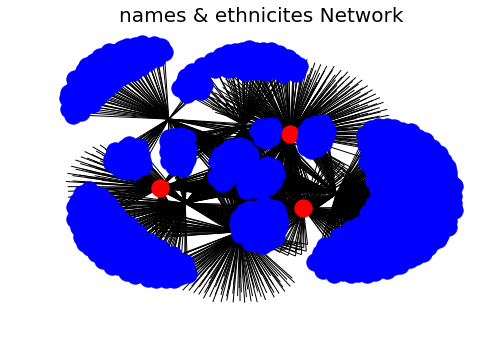

In [136]:
#visualize
net.draw(G, nodelist = ethcty, node_color = 'red')
net.draw(G, nodelist = nm, node_color = 'blue')
plt.title('names & ethnicites Network', fontsize = 20, color = 'black')
plt.show()

### Show how the nodes 'ethnicites' are connected

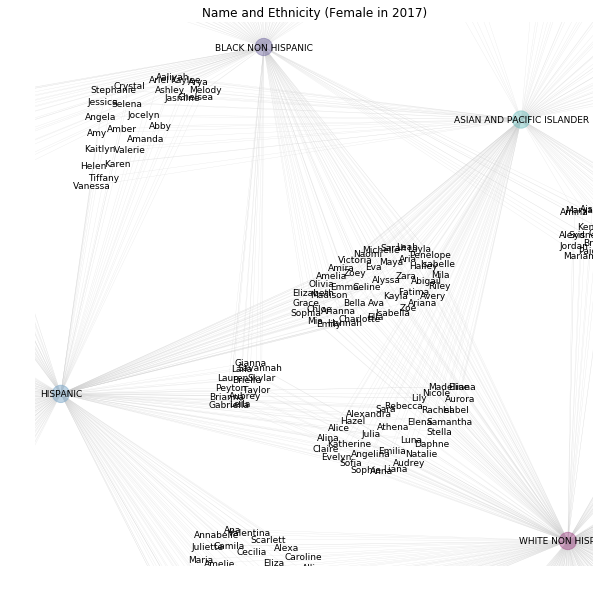

In [137]:
# choosing the plot size
plt.figure(figsize=(10,10))
ethnicity_list = list(df.ethcty.unique())


bsize = [G.degree(ethcty) * 10 for ethcty in ethcty]

layout = net.kamada_kawai_layout(G, scale=100)

eth_col = ['#76c2c1', '#776EA3', '#7ba7c8','#A34E8A']

# draw the nodes
net.draw_networkx_nodes(G, layout, alpha = .5, nodelist = ethnicity_list, node_color = eth_col)

# draw edges with color
edges = G.edges()
net.draw_networkx_edges(G, layout, width=0.25, alpha=.5, edge_color='#c6c6c6')


# add the node labels
net.draw_networkx_labels(G, layout, font_size=9)

## plot graph
plt.axis('off')
plt.title('Name and Ethnicity (Female in 2017)')
plt.show()

Looking on the data of 2017 females names in NYC we can see from the plots above how the 654 nodes are connected with the common names between the four ethnicites and the WHITE NON HISPANIC has the most nodes.

The graphs also tell us there are few names are more common in certain ethnicites than others while there are names that are not common at all.

# Centrality Measures
Centrality measures will be calculated to have understanding of important nodes within the network,and degree of interactions with other nodes. Degree centrality by category(ethnicity) will be calculated as well.

Statistical Analysis on Centrality Measure: With centrality measures calculated on each nodes by category, we can calculate average across these groups and apply t-tests to see if there are statistically significant differences in average degree cewntrality and Eigenvector centrality across ethnic groups.

In [138]:
#Network with ethnicity as nodes
G1 = net.Graph()
G1 = net.from_pandas_edgelist(df, source= 'nm', target='nm',edge_attr=True)

#add the attributes
net.set_node_attributes(G1, df['rnk'], 'rank')
net.set_node_attributes(G1, df['cnt'], 'count')
print(net.info(G1))

Name: 
Type: Graph
Number of nodes: 650
Number of edges: 650
Average degree:   2.0000


In [145]:
#### create dataframe of graph centrality measures
cm1 = pd.DataFrame(G1)

cm1['degree'] = net.degree_centrality(G1).values()
cm1['betweenness'] = net.betweenness_centrality(G1).values()
cm1['closeness'] = net.closeness_centrality(G1).values()
cm1['eigen'] = net.eigenvector_centrality_numpy(G1).values() 
cm1.index = list(G1)

# view centrality measures across ethnicities
dat1 = cm1.reset_index()
dat1.sort_values('degree' ,ascending = False).head(5)

,index,0,degree,betweenness,closeness,eigen
0,Olivia,Olivia,0.003082,0.0,0.0,-0.007896
446,Dina,Dina,0.003082,0.0,0.0,-0.014755
428,Amelie,Amelie,0.003082,0.0,0.0,-0.024078
429,Nayla,Nayla,0.003082,0.0,0.0,-0.000410
430,Anabella,Anabella,0.003082,0.0,0.0,0.002637


#### A look at few of the most popular female names in NYC 2017

#### The dataframe above can show us the differences and the diversities of names between the above ethnicity groups.

## Visualizing Centrality Measures

### Betweenness Centrality¶

Betweenness is a measure of the degree to which nodes serve as bridges or bottlenecks between parts of the network. Nodes with betweenness connect parts of a network that would not otherwise be connected.


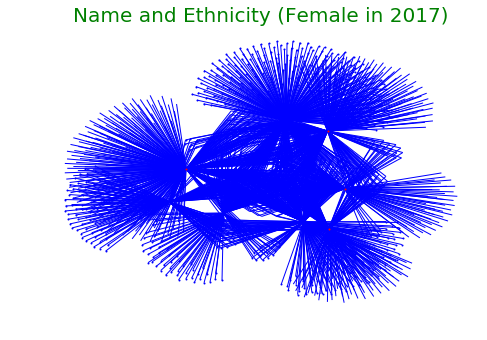

In [146]:
#plot scaled by betweenness centrality
net.draw(G, nodelist = ethcty, node_color = 'red', node_size=[v * 100 for v in list(network.betweenness)], edge_color="b")
net.draw(G, nodelist = nm, node_color = 'blue', node_size=[v * 100 for v in list(network.betweenness)], edge_color="b")

plt.title('Name and Ethnicity (Female in 2017)', fontsize = 20, color = 'Green')
plt.show()

### Closeness Centrality¶

In closeness centrality we calculate for each node the average shortest path to any node on the network


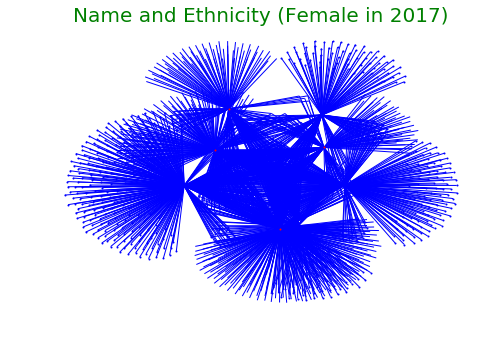

In [147]:
#plot scaled by closeness centrality
net.draw(G, nodelist = ethcty, node_color = 'red', node_size=[v * 100 for v in list(network.closeness)], edge_color="b")
net.draw(G, nodelist = nm, node_color = 'blue', node_size=[v * 100 for v in list(network.closeness)], edge_color="b")

plt.title('Name and Ethnicity (Female in 2017)', fontsize = 20, color = 'Green')
plt.show()

## Degree

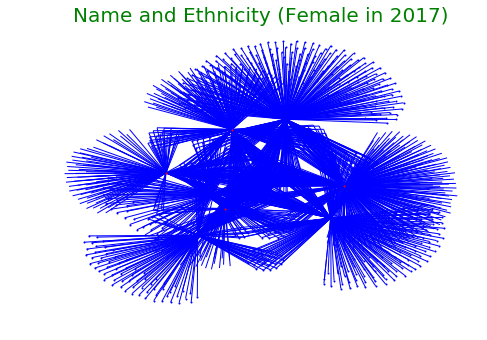

In [140]:
#plot scaled by degree centrality

net.draw(G, nodelist = ethcty, node_color = 'red', node_size=[v * 100 for v in list(network.degree)], edge_color="b")
net.draw(G, nodelist = nm, node_color = 'blue', node_size=[v * 100 for v in list(network.degree)], edge_color="b")


plt.title('Name and Ethnicity (Female in 2017)', fontsize = 20, color = 'Green')
plt.show()

### Eigenvector Centrality

It is a measure of whether a node knows well-connected people. like a weighted version of degree centrality, where the centrality metric for a node is the sum of all of the degrees possessed by the neighbors normalized by the largest value. This process is repeated until the largest value stops changing.

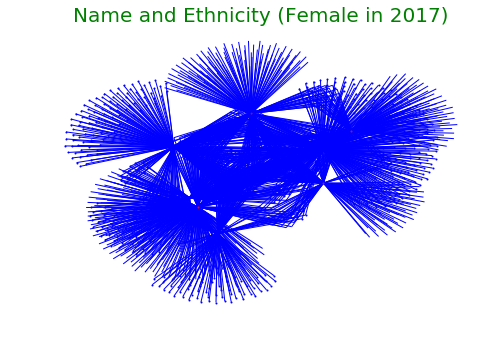

In [141]:
#plot scaled by eigen

net.draw(G, nodelist = ethcty, node_color = 'red', node_size=[v * 100 for v in list(network.eigen)], edge_color="b")
net.draw(G, nodelist = nm, node_color = 'blue', node_size=[v * 100 for v in list(network.eigen)], edge_color="b")

plt.title('Name and Ethnicity (Female in 2017)', fontsize = 20, color = 'Green')
plt.show()

# Conclusions
Looking at the ethnicites degree it can vary between 0.2634 to 0.5926 while the betweenness is between 0.1798 to 0.6251 accross all ethnicites.

The closeness is between 0.40 and 0.55 and eigen verctor centrality is the highest with the largest group which is the white non hispanic.